Copyright (c) 2017-2019 [Serpent-Tools developer team](https://github.com/CORE-GATECH-GROUP/serpent-tools/graphs/contributors), GTRC

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Results Reader

##  Basic operations

This notebook demonstrates the capabilities of the serpentTools to read Serpent results files. SERPENT [1] produces a result file (i.e. `_res.m`), containing general results (e.g. `k-eff`), metadata (e.g. `title`) and homogenized cross-sections. The homogenized cross-section sets are printed in the results file for all the requested universes. The ResultsReader is capable of reading this file, and storing the data inside univ objects. Each such object has methods and attributes that should ease the analyses.

In [1]:
import numpy as np
import serpentTools
from serpentTools.settings import rc
rc['serpentVersion'] = '2.1.30'

In [2]:
%time
resFile = 'InnerAssembly_res.m'
res = serpentTools.readDataFile(resFile)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.29 µs


# Metadata

`metadata` is a collective data that describes the problem. These are values that do not change over burnup and across homogenized universes. The following data is included: titles, data paths, and other descriptive data exist on the reader.

In [3]:
print(res.metadata['version'])  # Serpent version used for the execution
print(res.metadata['decayDataFilePath'])  # Directory path for data libraries
print(res.metadata['inputFileName'])  # Directory path for data libraries

Serpent 2.1.30
/nv/hp22/dkotlyar6/data/Codes/DATA/endfb7/sss_endfb7.dec
InnerAssembly


In [4]:
res.metadata.keys()

dict_keys(['version', 'compileDate', 'debug', 'title', 'confidentialData', 'inputFileName', 'workingDirectory', 'hostname', 'cpuType', 'cpuMhz', 'startDate', 'completeDate', 'pop', 'cycles', 'skip', 'batchInterval', 'srcNormMode', 'seed', 'ufsMode', 'ufsOrder', 'neutronTransportMode', 'photonTransportMode', 'groupConstantGeneration', 'b1Calculation', 'b1BurnupCorrection', 'implicitReactionRates', 'optimizationMode', 'reconstructMicroxs', 'reconstructMacroxs', 'doubleIndexing', 'mgMajorantMode', 'spectrumCollapse', 'mpiTasks', 'ompThreads', 'mpiReproducibility', 'ompReproducibility', 'ompHistoryProfile', 'shareBufArray', 'shareRes2Array', 'xsDataFilePath', 'decayDataFilePath', 'sfyDataFilePath', 'nfyDataFilePath', 'braDataFilePath'])

In [5]:
res.metadata['startDate']

'Sat Apr 28 06:09:54 2018'

In [6]:
res.metadata['pop'], res.metadata['skip']  , res.metadata['cycles']

(5000, 10, 50)

# Results Data

Results are stored as a function of time/burnup/index and include integral parameters of the system.
Results, such as `k-eff`, total `flux`, and execution times are included in `.resdata`. Some results include values and uncertainities (e.g. criticality) and some just the values (e.g. CPU resources). 

In [7]:
list(res.resdata.keys())[0:5]

['minMacroxs', 'dtThresh', 'stFrac', 'dtFrac', 'dtEff']

Values are presented in similar fashion as if they were read in to Matlab, with one exception. Serpent currently appends a new row for each burnup step, but also for each homogenized universe. This results in repetition of many quantities as Serpent loops over group constant data. The `ResultsReader` understands Serpent outputs and knows when to append "new" result data to avoid repetition. 

The structure of the data is otherwise identical to Matlab. For many quantities, the first column indicates expected value, while the second column contains relative uncertainties. For a better reference, please consult the Serpent wiki on structure of the main output file.

In [8]:
res.resdata['absKeff']

array([[1.29160e+00, 9.00000e-04],
       [1.29500e+00, 9.30000e-04],
       [1.29172e+00, 9.10000e-04],
       [1.29172e+00, 7.80000e-04],
       [1.29312e+00, 6.80000e-04],
       [1.29140e+00, 7.80000e-04]])

In [9]:
res.resdata['absKeff'][:,0]

array([1.2916 , 1.295  , 1.29172, 1.29172, 1.29312, 1.2914 ])

In [10]:
res.resdata['burnup']

array([[0.      , 0.      ],
       [0.1     , 0.100001],
       [1.      , 1.00001 ],
       [2.      , 2.00001 ],
       [3.      , 3.00003 ],
       [4.      , 4.00004 ]])

In [11]:
res.resdata['burnDays']

array([[ 0.     ],
       [ 1.20048],
       [12.0048 ],
       [24.0096 ],
       [36.0144 ],
       [48.0192 ]])

In [12]:
res.resdata['totCpuTime']

array([[10.814 ],
       [20.3573],
       [30.0783],
       [39.4965],
       [48.919 ],
       [58.6448]])

## Plotting Results Data
The `ResultsReader` has a versatile plot method, used to plot primary time-dependent data from the result file. With it, one can plot
data from one or more quanties against various metrics of time. Control over formatting axis, legend placement, and label formatting is easily yielded to the user.

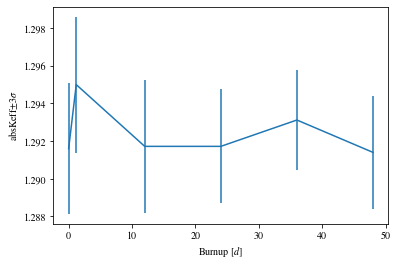

In [13]:
res.plot('absKeff')

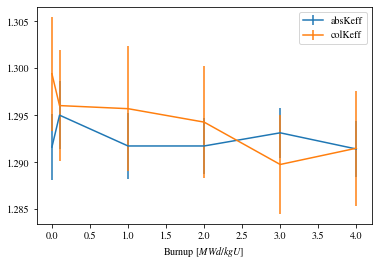

In [14]:
res.plot('burnup', ['absKeff', 'colKeff'])

Pass a dictionary of ``{variable: label}`` pairs to set plot labels

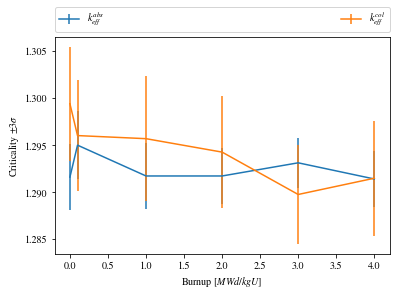

In [15]:
# plot multiple values with better labels and formatting
res.plot(
    'burnup', {'absKeff': '$k_{eff}^{abs}$', 'colKeff': '$k_{eff}^{col}$'},
    ylabel=r'Criticality $\pm 3\sigma$',
    legend='above', ncol=2)

Using the `right` argument, quantities can be plotted on the left and right y-axis. Similar formatting options are available

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa54cdec9d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa54cd87d90>)

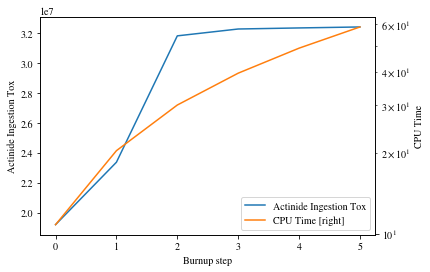

In [16]:
res.plot(
    'burnStep', {'actinideIngTox': 'Actinide Ingestion Tox'},
    right={'totCpuTime': "CPU Time [right]"}, sigma=0, rightlabel='CPU Time', 
    logy=[False, True])

# Homogenized Universes

Universe data is stored for each state point in the `universes` dictionary. Keys are `UnivTuple` representing `('univ',burnup, step, time)`

* `'univ'`: universe ID (e.g., `'0'`)
* `burnup`: in MWd/kg
* `step`: step index, 
* `time`: in days.  
and can be indexes by attribute or by position.

In [17]:
for key in sorted(res.universes):
    break
key

UnivTuple(universe='0', burnup=0.0, step=0, days=0.0)

In [18]:
key[0]

'0'

In [19]:
assert key.burnup == key[1]

Results, such as infinite cross-sections, b1-leakage corrected cross-sections, kinetic parameters, are included in `.universes`. All the results include values and uncertainties. 

In [20]:
res.universes.keys()

dict_keys([UnivTuple(universe='3101', burnup=0.0, step=0, days=0.0), UnivTuple(universe='3102', burnup=0.0, step=0, days=0.0), UnivTuple(universe='0', burnup=0.0, step=0, days=0.0), UnivTuple(universe='3101', burnup=0.1, step=1, days=1.20048), UnivTuple(universe='3102', burnup=0.1, step=1, days=1.20048), UnivTuple(universe='0', burnup=0.1, step=1, days=1.20048), UnivTuple(universe='3101', burnup=1.0, step=2, days=12.0048), UnivTuple(universe='3102', burnup=1.0, step=2, days=12.0048), UnivTuple(universe='0', burnup=1.0, step=2, days=12.0048), UnivTuple(universe='3101', burnup=2.0, step=3, days=24.0096), UnivTuple(universe='3102', burnup=2.0, step=3, days=24.0096), UnivTuple(universe='0', burnup=2.0, step=3, days=24.0096), UnivTuple(universe='3101', burnup=3.0, step=4, days=36.0144), UnivTuple(universe='3102', burnup=3.0, step=4, days=36.0144), UnivTuple(universe='0', burnup=3.0, step=4, days=36.0144), UnivTuple(universe='3101', burnup=4.0, step=5, days=48.0192), UnivTuple(universe='3102

One can directly index into the `universes` dictionary to obtain data for a specific universe.

In [21]:
print(res.universes['0', 0, 0, 0])

<HomogUniv 0: burnup: 0.00000E+00 MWd/kgU, 0.00000E+00 days>


However this requires knowledge of all four parameters which may be difficult. The `getUniv` method retrieves a specific universe that matches universe id and time of interest. 
While all four identifers, (universe id, burnup, step, and time) can be provided, the latter three are usually redundant.

In [22]:
univ0 = res.getUniv('0', index=0)  
print(univ0)

<HomogUniv 0: burnup: 0.00000E+00 MWd/kgU, 0.00000E+00 days>


In [23]:
univ3101 = res.getUniv('3101', index=3)
print(univ3101)

<HomogUniv 3101: burnup: 2.00000E+00 MWd/kgU, 2.40096E+01 days>


In [24]:
univ3102 = res.getUniv('3102', burnup=0.1)
print(univ3102)

<HomogUniv 3102: burnup: 1.00000E-01 MWd/kgU, 1.20048E+00 days>


In [25]:
print(res.getUniv('0', timeDays=24.0096))

<HomogUniv 0: burnup: 2.00000E+00 MWd/kgU, 2.40096E+01 days>


## Working with homogenized universe data
Each state contains the same data fields, which can be obatined by using the following attributes on the `HomogUniv` objects: 

* `infExp`: infinite values, e.g. `INF_ABS`, 

* `infUnc`: infinite uncertainties, 

* `b1Exp`:  b1 (leakage corrected) values, e.g. `B1_ABS`,  

* `b1Exp`:  b1 (leakage corrected) uncertainties, 

* `gc`: variables that are not included in 'inf' or 'b1', e.g. `BETA`

* `gcUnc`: group uncertainties

* `groups`: macro energy group structure, MeV

* `microGroups`: micro energy group structure, MeV

The parser reads all variables by default, and the `HomogUniv` objects stores data in various dictionaries. Data are energy dependent, exactly as they would appear in Serpent outputs.

In [26]:
univ0.infExp.keys()

dict_keys(['infMicroFlx', 'infKinf', 'infFlx', 'infFissFlx', 'infTot', 'infCapt', 'infAbs', 'infFiss', 'infNsf', 'infNubar', 'infKappa', 'infInvv', 'infScatt0', 'infScatt1', 'infScatt2', 'infScatt3', 'infScatt4', 'infScatt5', 'infScatt6', 'infScatt7', 'infScattp0', 'infScattp1', 'infScattp2', 'infScattp3', 'infScattp4', 'infScattp5', 'infScattp6', 'infScattp7', 'infTranspxs', 'infDiffcoef', 'infRabsxs', 'infRemxs', 'infI135Yield', 'infXe135Yield', 'infPm147Yield', 'infPm148Yield', 'infPm148mYield', 'infPm149Yield', 'infSm149Yield', 'infI135MicroAbs', 'infXe135MicroAbs', 'infPm147MicroAbs', 'infPm148MicroAbs', 'infPm148mMicroAbs', 'infPm149MicroAbs', 'infSm149MicroAbs', 'infXe135MacroAbs', 'infSm149MacroAbs', 'infChit', 'infChip', 'infChid', 'infS0', 'infS1', 'infS2', 'infS3', 'infS4', 'infS5', 'infS6', 'infS7', 'infSp0', 'infSp1', 'infSp2', 'infSp3', 'infSp4', 'infSp5', 'infSp6', 'infSp7'])

In [27]:
univ0.infExp['infAbs']

array([0.0170306 , 0.0124957 , 0.00777066, 0.00773255, 0.00699608,
       0.00410746, 0.00334604, 0.00296948, 0.0030725 , 0.00335412,
       0.00403133, 0.00506587, 0.00651475, 0.00737292, 0.00907442,
       0.0113446 , 0.0125896 , 0.0164987 , 0.0181642 , 0.0266464 ,
       0.0292439 , 0.0315338 , 0.0463069 , 0.0807952 ])

In [28]:
univ0.infExp['infFlx']

array([1.10460e+15, 1.72386e+16, 7.78465e+16, 1.70307e+17, 2.85783e+17,
       4.61226e+17, 8.04999e+17, 1.17536e+18, 1.17488e+18, 1.26626e+18,
       1.03476e+18, 7.58885e+17, 4.95687e+17, 5.85369e+17, 2.81921e+17,
       1.16665e+17, 8.06833e+16, 2.26450e+16, 6.51541e+16, 2.79929e+16,
       8.87468e+15, 1.70822e+15, 8.87055e+14, 6.22266e+13])

Uncertainties can be obtained by using the `infUnc`, `b1Unc`, and `gcUnc` dictionaries. Uncertainties are relative, as they appear in the output files.

In [29]:
univ0.infUnc['infFlx']

array([0.02125, 0.0287 , 0.00901, 0.00721, 0.00441, 0.00434, 0.00448,
       0.0007 , 0.00369, 0.00071, 0.00045, 0.00133, 0.00061, 0.00341,
       0.00674, 0.00197, 0.00802, 0.00368, 0.00127, 0.00046, 0.02806,
       0.0491 , 0.19529, 0.16476])

Serpent also outputs the `B1` cross-sections. However, the user must enable the `B1` option by setting the [`fum` card](http://serpent.vtt.fi/mediawiki/index.php/Input_syntax_manual#set_fum). If this card is not enabled by the user, the `B1_` variables will all be zeros. 

In [30]:
univ0.b1Exp.keys()

dict_keys(['b1MicroFlx', 'b1Kinf', 'b1Keff', 'b1B2', 'b1Err', 'b1Flx', 'b1FissFlx', 'b1Tot', 'b1Capt', 'b1Abs', 'b1Fiss', 'b1Nsf', 'b1Nubar', 'b1Kappa', 'b1Invv', 'b1Scatt0', 'b1Scatt1', 'b1Scatt2', 'b1Scatt3', 'b1Scatt4', 'b1Scatt5', 'b1Scatt6', 'b1Scatt7', 'b1Scattp0', 'b1Scattp1', 'b1Scattp2', 'b1Scattp3', 'b1Scattp4', 'b1Scattp5', 'b1Scattp6', 'b1Scattp7', 'b1Transpxs', 'b1Diffcoef', 'b1Rabsxs', 'b1Remxs', 'b1I135Yield', 'b1Xe135Yield', 'b1Pm147Yield', 'b1Pm148Yield', 'b1Pm148mYield', 'b1Pm149Yield', 'b1Sm149Yield', 'b1I135MicroAbs', 'b1Xe135MicroAbs', 'b1Pm147MicroAbs', 'b1Pm148MicroAbs', 'b1Pm148mMicroAbs', 'b1Pm149MicroAbs', 'b1Sm149MicroAbs', 'b1Xe135MacroAbs', 'b1Sm149MacroAbs', 'b1Chit', 'b1Chip', 'b1Chid', 'b1S0', 'b1S1', 'b1S2', 'b1S3', 'b1S4', 'b1S5', 'b1S6', 'b1S7', 'b1Sp0', 'b1Sp1', 'b1Sp2', 'b1Sp3', 'b1Sp4', 'b1Sp5', 'b1Sp6', 'b1Sp7'])

In [31]:
univ0.b1Exp['b1Flx']

array([1.39800e+15, 2.22121e+16, 1.00380e+17, 2.19050e+17, 3.61071e+17,
       5.61244e+17, 9.33086e+17, 1.28335e+18, 1.21094e+18, 1.24502e+18,
       9.62426e+17, 6.70263e+17, 4.23191e+17, 4.69164e+17, 2.14577e+17,
       8.77042e+16, 5.98583e+16, 1.67291e+16, 4.72542e+16, 1.96319e+16,
       6.00800e+15, 1.12777e+15, 5.79412e+14, 3.93280e+13])

In [32]:
univ0.b1Exp['b1Abs']

array([0.0170306 , 0.0124977 , 0.00777041, 0.00773244, 0.00700272,
       0.00410942, 0.00335046, 0.00296957, 0.00307219, 0.00335169,
       0.00402825, 0.00506175, 0.00651283, 0.00736592, 0.00907107,
       0.0113432 , 0.012588  , 0.0165002 , 0.018157  , 0.0266812 ,
       0.029204  , 0.0315299 , 0.0462994 , 0.0807952 ])

Data that does not contain the prefix `INF_` or `B1_` is stored under the `gc` and `gcUnc` fields. Criticality, kinetic, and other variables are stored under this field.  

In [33]:
univ3101.gc.keys()

dict_keys(['cmmTranspxs', 'cmmTranspxsX', 'cmmTranspxsY', 'cmmTranspxsZ', 'cmmDiffcoef', 'cmmDiffcoefX', 'cmmDiffcoefY', 'cmmDiffcoefZ', 'betaEff', 'lambda'])

In [34]:
univ3101.gc['betaEff']

array([3.04272e-03, 8.93131e-05, 6.59324e-04, 5.62858e-04, 1.04108e-03,
       5.67326e-04, 1.22822e-04])

Macro- and micro-group structures are stored directly in the universe in MeV as they appear in the Serpent output files. This means that the macro-group structure is in order of descending energy, while micro-group are in order of increasing energy.

In [35]:
univ3101.groups

array([1.0000e+37, 1.0000e+01, 6.0653e+00, 3.6788e+00, 2.2313e+00,
       1.3534e+00, 8.2085e-01, 4.9787e-01, 3.0197e-01, 1.8316e-01,
       1.1109e-01, 6.7380e-02, 4.0868e-02, 2.4788e-02, 1.5034e-02,
       9.1188e-03, 5.5309e-03, 3.3546e-03, 2.0347e-03, 1.2341e-03,
       7.4852e-04, 4.5400e-04, 3.1203e-04, 1.4894e-04, 0.0000e+00])

In [36]:
univ3101.microGroups[:5:]

array([1.0000e-10, 1.4894e-04, 1.6525e-04, 1.8156e-04, 1.9787e-04])

## Plotting universes

``HomogUniv`` objects can plot group constants using their ``plot`` method. This method has a range of formatting options, with defaults corresponding to plotting macroscopic cross sections. This is manifested in the default y axis label, but can be easily adjusted. 

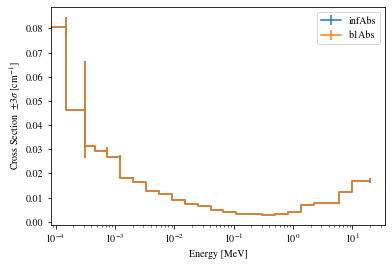

In [37]:
univ0.plot(['infAbs', 'b1Abs']);

Macroscopic and microscopic quantities, such as micro-group flux, can be plotted on the same figure.
**Note** The units and presentation of the micro- and macro-group fluxes are dissimilar, and the units do not agree with that of the assumed group constants. This will adjust the default y-label, as demonstrated below.

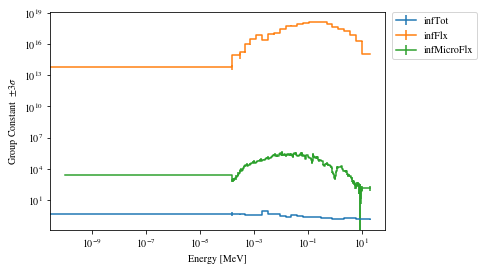

In [38]:
univ0.plot(['infTot', 'infFlx', 'infMicroFlx'], legend='right');

For plotting data from multiple universes, pass the returned [`matplotlib.axes.Axes`](https://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes) object, on which the plot was drawn, into the plot method for the next universe. The `labelFmt` argument can be used to differentiate between plotted data. The following strings are replaced when creating the labels:

|String|Replaced value|
|-|-|
|`{k}`|Name of variable plotted|
|`{u}`| Name of this universe|
|`{b}`| Value of burnup in MWd/kgU|
|`{d}`| Value of burnup in days|
|`{i}`| Burnup index

These can be used in conjunction with the [`matplotlib` $\LaTeX$ rendering](https://matplotlib.org/users/usetex.html) system.

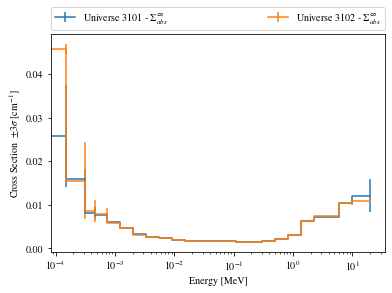

In [39]:
fmt = r"Universe {u} - $\Sigma_{abs}^\infty$"
ax = univ3101.plot('infFiss', labelFmt=fmt)
univ3102.plot('infFiss', ax=ax, labelFmt=fmt, legend='above', ncol=2);

##  User Defined Settings

The user is able to filter the required information by using the settings option.

A detailed description on how to use the settings can be found on:
http://serpent-tools.readthedocs.io/en/latest/settingsTop.html

In [40]:
from serpentTools.settings import rc

In [41]:
rc.keys()

dict_keys(['branching.intVariables', 'branching.floatVariables', 'depletion.metadataKeys', 'depletion.materialVariables', 'depletion.materials', 'depletion.processTotal', 'detector.names', 'verbosity', 'sampler.allExist', 'sampler.freeAll', 'sampler.raiseErrors', 'sampler.skipPrecheck', 'serpentVersion', 'xs.getInfXS', 'xs.getB1XS', 'xs.reshapeScatter', 'xs.variableGroups', 'xs.variableExtras', 'microxs.getFlx', 'microxs.getXS', 'microxs.getFY'])

The `rc` object and various `xs.*` settings can be used to control the `ResultsReader`. Specifically, these settings can be used to store only specific bits of information. Here, we will store the version of Serpent, various cross sections, eigenvalues, and burnup data.

In [42]:
rc['xs.variableGroups'] = ['versions', 'xs', 'eig', 'burnup-coeff']

Further, instruct the reader to only read infinite medium cross sections, not critical spectrum B1 cross sections.

In [43]:
rc['xs.getB1XS'] = False

In [44]:
resFilt = serpentTools.readDataFile(resFile)

In [45]:
resFilt.metadata.keys()

dict_keys(['version', 'compileDate', 'debug', 'title', 'confidentialData', 'inputFileName', 'workingDirectory', 'hostname', 'cpuType', 'cpuMhz', 'startDate', 'completeDate'])

In [46]:
resFilt.resdata.keys()

dict_keys(['burnMaterials', 'burnMode', 'burnStep', 'burnup', 'burnDays', 'nubar', 'anaKeff', 'impKeff', 'colKeff', 'absKeff', 'absKinf', 'geomAlbedo'])

In [47]:
univ0Filt = resFilt.getUniv('0', index=1)  

In [48]:
univ0Filt.infExp.keys() 

dict_keys(['infTot', 'infCapt', 'infAbs', 'infFiss', 'infNsf', 'infNubar', 'infKappa', 'infInvv', 'infScatt0', 'infScatt1', 'infScatt2', 'infScatt3', 'infScatt4', 'infScatt5', 'infScatt6', 'infScatt7', 'infTranspxs', 'infDiffcoef', 'infRabsxs', 'infRemxs', 'infChit', 'infChip', 'infChid', 'infS0', 'infS1', 'infS2', 'infS3', 'infS4', 'infS5', 'infS6', 'infS7'])

In [49]:
univ0Filt.b1Exp

{}